In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from matplotlib import dates as mdates
import numpy as np
from matplotlib.ticker import MaxNLocator

In [4]:
free_time = list(pd.read_excel("data/выходные и праздники.xlsx")['ВП']) #список с выходными и праздниками
def dict_splits_share(free_time):
    file_path_moex = "data/stock-index-base-moex-rts-18122012-nowadays.xlsx" #путь к файлу с Number of issued shares и Free-float factor
# Дальше в функции создается вложенный словарь, где ключ дата, а значение словарь. Вложенный словарь: ключ в виде акции, значение произведение Number of issued shares и Free-float factor
#Такой словарь создается на каждую дату
    sheet_names = pd.ExcelFile(file_path_moex).sheet_names[-1::-1]

    dict_with_multiply = {}
    for paper in sheet_names:
        dates_col = pd.read_excel(
            "data/stock-index-base-moex-rts-18122012-nowadays.xlsx",
            sheet_name=f'{paper}').head(1)

        values = list(
            pd.read_excel(
                "data/stock-index-base-moex-rts-18122012-nowadays.xlsx",
                sheet_name=f'{paper}', skiprows=3)['Code'].str.strip())

        values_multiply = list(
            pd.read_excel(
                "data/stock-index-base-moex-rts-18122012-nowadays.xlsx",
                sheet_name=f'{paper}', skiprows=3)['multiply'])

        start_date = dates_col['First date'][0]
        end_date = dates_col['Last date'][0]
        dates = list(pd.date_range(start=start_date, end=end_date))
        for date in dates:
            if date not in free_time:
                d = dict(zip(values, values_multiply))
                dict_with_multiply.update([(date, d)])
    splits_df = pd.read_csv("data/splits.csv")
    date_splits = list(splits_df['Date'])
    splits_dict = {}
#Сплиты заданы словарями. Ключом является дата, а значением вложенный словарь. Во вложенном словаре, ключом выступает акция, а значением коэффициент сплита
    for date in date_splits:
        element = splits_df.loc[splits_df['Date'] == date]
        tick = list(element['ticker'])
        coef = list(element['Stock Splits'])
        d = dict(zip(tick, coef))
        splits_dict.update([(datetime.strptime(date, '%Y-%m-%d'), d)])

    return  dict_with_multiply, splits_dict

cap, spl = dict_splits_share(free_time)

In [5]:
def model(cap, spl, free_time):
    #функция где происходит моделирование
    test_price = []
    all_split = []

    test_pre_index = []
    test_adjsmvt0 = []
    test_adjsmvt = []
    test_n = []
    index_moex = []
    flag = False
    stocks_table = pd.read_csv("data/для моделирования2.csv") #Основной файл с ценами. Если акция не присутствует в индексе в определенный день, то цена акции 0
    stocks_table['date'] = pd.to_datetime(stocks_table['date'])

    dates = list(stocks_table['date'])
    stocks_table = stocks_table.set_index('date')
    keys_spl = list(spl.keys()) #даты со сплитаами
    rebalance_date = list(pd.to_datetime(pd.read_excel("data/даты нового состава и ребалансировки.xlsx")['rebalance'])) # Даты ребалансировок
# Заданы константами, чтобы питон не ругался
    adjsmvt0 = 1
    spl_t = 1
    rebalance_index = 100
    for index, price in stocks_table.iterrows():
        splits_now = []
        price = price.loc[price != 0] #Цены которые  присутствуют в индексе на конкретную дату
        n = len(price) # Количество акций в конкретный день
        if n == 0 or index in free_time: # Выходной день выкалываем сразу
            print('выходной или 0')
            dates.remove(index)
            continue
        d_capital = pd.Series(cap[index]) # Подтягиваем словарь на конкретную дату с произведением Number of issued shares и Free-float factor

        if index in rebalance_date: #Ребалансировка. Пересчет делителя

            adjsmvt0 = (price * d_capital).dropna()
            flag = False
            print('поменялось adjsmvt0 при ребалансировке', index)

        if index in keys_spl: #Сплиты. Цикл прогоняет по датам сплитов. Если на дату приходится сплит, то смотрит есть ли у какой-то акции сплит. Задается новый индекс, пересчитывается делитель. Флаг в положении False, значит теперь множитель сплита в числителе до следующей ребалансировки
            papers = list(spl[index].keys())
            papers_iterrow = list(price.to_dict().keys())
            for pap in papers_iterrow:
                if pap in papers:
                    spl_t = pd.Series(spl[index]).dropna()
                    adjsmvt0 = (price * d_capital.mul(spl_t, fill_value=1)).dropna()
                    splits_now.append(index)
                    all_split.append(index)
                    flag = True
                    rebalance_index = index_moex[-1]
                    print('поменялось adjsmvt0 при сплите', index, 'ребалансировочный индекс---',rebalance_index)
                    break

        if flag == False: # Если сплитов нет, то числитель не домножается на коэффициент сплита.
            adjsmvt = (price * d_capital).dropna()
        else:
            adjsmvt = price * d_capital.mul(spl_t, fill_value=1)
        i = rebalance_index * sum((adjsmvt / adjsmvt0).dropna().values) * 1 / n
        if ((index in rebalance_date or index in splits_now) and index != rebalance_date[0]): #Выбор нового индекса для домножения.
            rebalance_index = index_moex[-1]
            print('Новый ребалансировочный индекс----', rebalance_index)

        if index in rebalance_date or index in splits_now:# Присваиваем последний индекс при событии(для сохранения непрерывности)
            i = rebalance_index


        if i != 0.0: #Дополнительная страховка на случай если был выходной.
            print(i, index)
            test_pre_index.append(rebalance_index)
            test_adjsmvt0.append(adjsmvt0.dropna())
            test_adjsmvt.append(adjsmvt.dropna())
            test_n.append(n)
            index_moex.append(i)
            test_price.append(price)
        else:

            dates.remove(index)

    df = pd.DataFrame({'Дата':dates, 'Индекс':index_moex, 'Множитель индекса':test_pre_index,'Цены':test_price, 'adjsmvt':test_adjsmvt, 'adjsmvt0':test_adjsmvt0, 'N':test_n})
    df.to_excel("data/тест.xlsx", index=False) # Создание файла для подробного разбора.
    return  all_split, index_moex, dates

all_split, index_custom, dates = model(cap, spl, free_time)

Выходные данные были обрезаны до нескольких последних строк (5000).
103.96997032850892 2012-01-23 00:00:00
103.30183892415546 2012-01-24 00:00:00
103.84311061809623 2012-01-25 00:00:00
105.78788080061685 2012-01-26 00:00:00
104.9871586564296 2012-01-27 00:00:00
выходной или 0
выходной или 0
103.7366722697563 2012-01-30 00:00:00
105.44062786446848 2012-01-31 00:00:00
107.3115741621489 2012-02-01 00:00:00
107.21976726137262 2012-02-02 00:00:00
109.04217335324019 2012-02-03 00:00:00
выходной или 0
выходной или 0
109.2864374233334 2012-02-06 00:00:00
108.6621529874556 2012-02-07 00:00:00
109.47432852982641 2012-02-08 00:00:00
108.34731520281177 2012-02-09 00:00:00
106.50155004877242 2012-02-10 00:00:00
выходной или 0
выходной или 0
109.00256954938277 2012-02-13 00:00:00
109.25064134225401 2012-02-14 00:00:00
110.48497409733508 2012-02-15 00:00:00
109.68466590389144 2012-02-16 00:00:00
109.76466445739 2012-02-17 00:00:00
выходной или 0
выходной или 0
110.55599801042348 2012-02-20 00:00:00
1

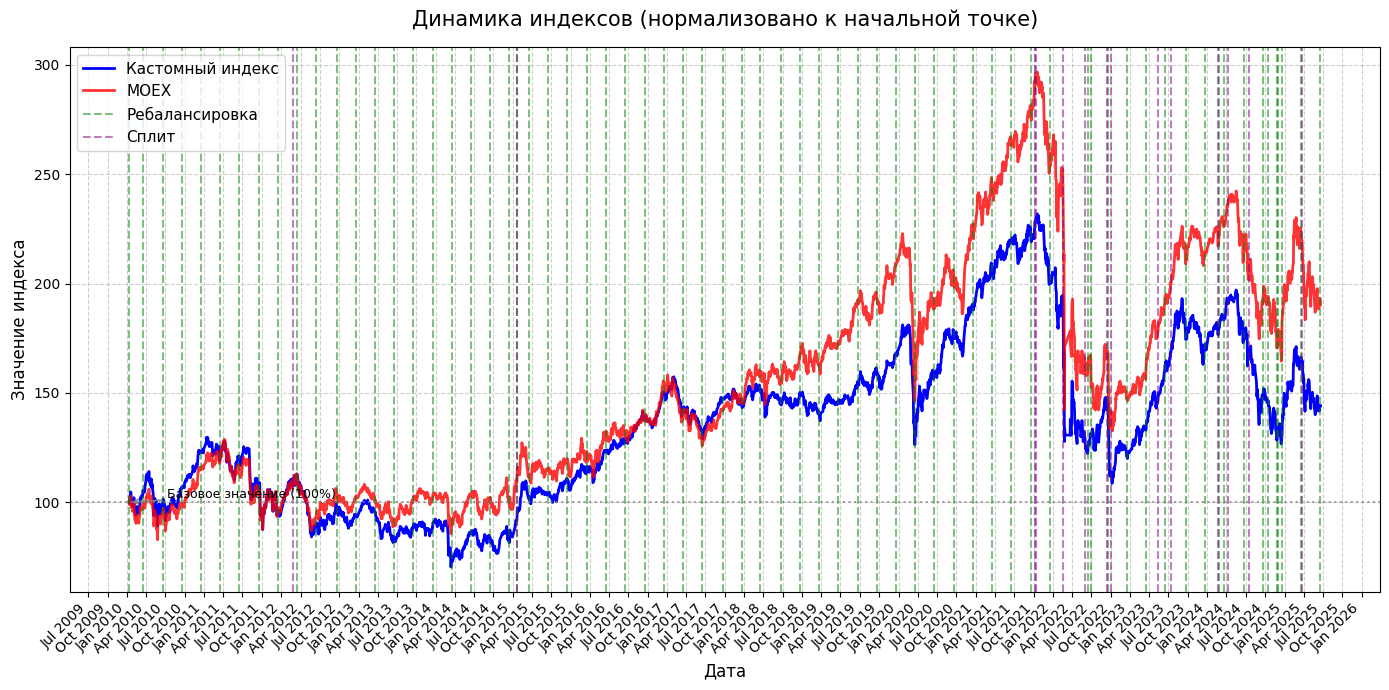

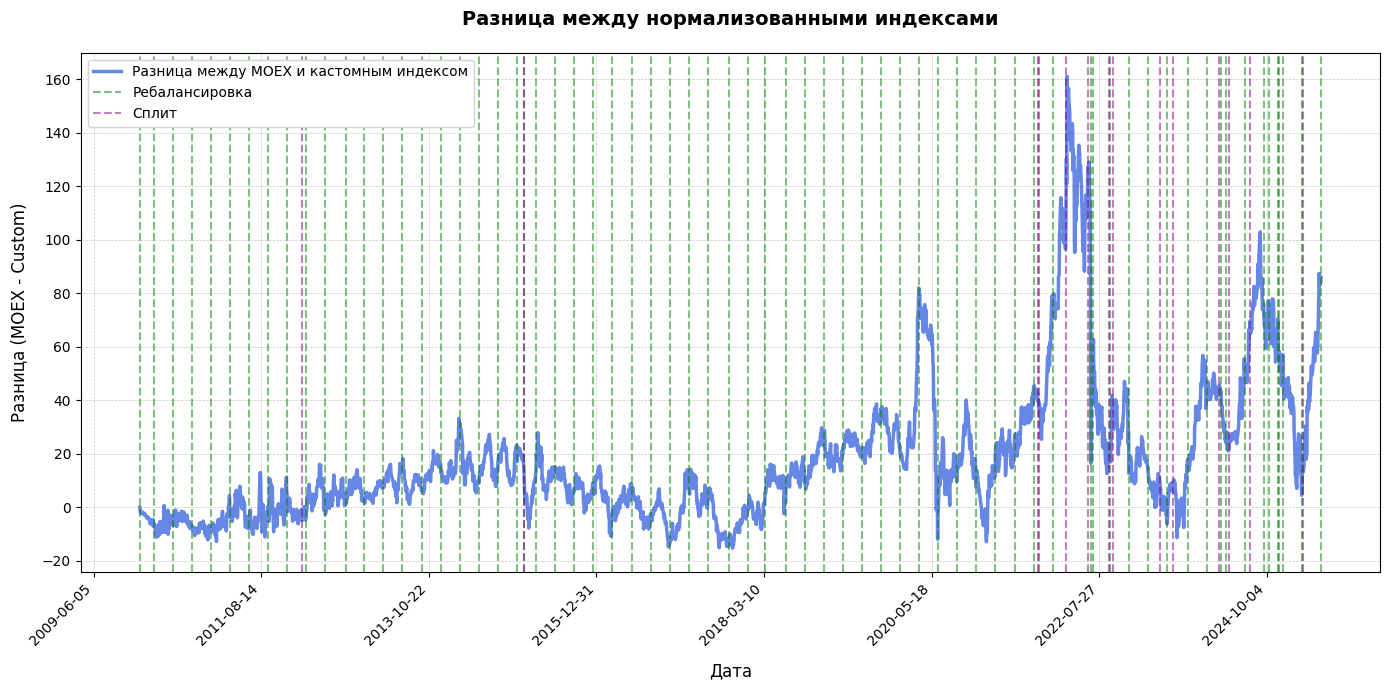

In [6]:
def visualization(index_custom, dates, all_split):
    moex_original = pd.read_csv("data/security.csv", sep=';', encoding='windows-1251', decimal=',',  thousands=' ',  dtype={'CLOSE': str})
    rebalance_date = list(pd.to_datetime(pd.read_excel("data/даты нового состава и ребалансировки.xlsx")['rebalance']))

    moex_original['CLOSE'] = (moex_original['CLOSE'].str.replace(',', '.').str.replace(' ', '').astype(float))


    date_moex = pd.to_datetime(moex_original['TRADEDATE'], format='%d.%m.%Y')
    coef_moex = moex_original['CLOSE'].values


    start_date = dates[0]
    custom_base = index_custom[0]
    moex_base = moex_original[moex_original['TRADEDATE'] == start_date.strftime('%d.%m.%Y')]['CLOSE'].values


    if len(moex_base) == 0:
        date_diff = [abs((pd.to_datetime(d) - start_date).days) for d in moex_original['TRADEDATE']]
        idx = np.argmin(date_diff)
        moex_base = coef_moex[idx]
    else:
        moex_base = moex_base[0]


    custom_norm = [x / custom_base * 100 for x in index_custom]
    moex_norm = [x / moex_base * 100 for x in coef_moex]
    plt.figure(figsize=(14, 7))
    plt.plot(dates, custom_norm, label='Кастомный индекс', color='blue', linewidth=2)
    plt.plot(date_moex, moex_norm, label='MOEX', color='red', linewidth=2, alpha=0.8)
    for i, date in enumerate(rebalance_date):
        if i == 0:
            plt.axvline(x=date, color='green', linestyle='--', alpha=0.5, linewidth=1.5, label='Ребалансировка')
        else:
            plt.axvline(x=date, color='green', linestyle='--', alpha=0.5, linewidth=1.5)

    for i, date in enumerate(all_split):
        if i == 0:
            plt.axvline(x=date, color='purple', linestyle='--', alpha=0.5, linewidth=1.5, label='Сплит')
        else:
            plt.axvline(x=date, color='purple', linestyle='--', alpha=0.5, linewidth=1.5)



    plt.title('Динамика индексов (нормализовано к начальной точке)', fontsize=15, pad=15)
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Значение индекса', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)


    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gcf().autofmt_xdate(rotation=45)


    plt.axhline(y=100, color='gray', linestyle=':', alpha=0.7)

    plt.legend(loc='best', fontsize=11)
    plt.annotate(f'Базовое значение (100%)',
                 xy=(start_date, 100),
                 xytext=(start_date + pd.DateOffset(months=6), 102),
                 arrowprops=dict(arrowstyle='->', color='gray'),
                 fontsize=9)

    plt.tight_layout()
    plt.show()

    raz = np.array(moex_norm[0:3798]) - np.array(custom_norm)


    plt.figure(figsize=(14, 7))
    plt.plot(dates, raz, color='royalblue', linewidth=2.5, alpha=0.8, label='Разница между MOEX и кастомным индексом')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.gca().xaxis.set_major_locator(MaxNLocator(10))
    plt.gca().yaxis.set_major_locator(MaxNLocator(10))
    for i, date in enumerate(rebalance_date):
        if i == 0:
            plt.axvline(x=date, color='green', linestyle='--', alpha=0.5, linewidth=1.5, label='Ребалансировка')
        else:
            plt.axvline(x=date, color='green', linestyle='--', alpha=0.5, linewidth=1.5)

    for i, date in enumerate(all_split):
        if i == 0:
            plt.axvline(x=date, color='purple', linestyle='--', alpha=0.5, linewidth=1.5, label='Сплит')
        else:
            plt.axvline(x=date, color='purple', linestyle='--', alpha=0.5, linewidth=1.5)



    plt.title('Разница между нормализованными индексами', fontsize=14, pad=20, fontweight='bold')
    plt.xlabel('Дата', fontsize=12, labelpad=10)
    plt.ylabel('Разница (MOEX - Custom)', fontsize=12, labelpad=10)
    plt.legend(loc='upper left', framealpha=1, facecolor='white', edgecolor='lightgray')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    return custom_norm, moex_norm


custom, origin = visualization(index_custom, dates, spl)

In [7]:
def quant_har(custom, origin):
    ewi = pd.Series(custom)
    moex = pd.Series(origin)
    mean_ewi = ewi.mean()
    mean_moex = moex.mean()
    median_ewi = ewi.median()
    median_moex = moex.median()
    min_ewi = ewi.min()
    min_moex = moex.min()
    max_ewi = ewi.max()
    max_moex = moex.max()
    range_ewi = ewi.max() - ewi.min()
    range_moex = moex.max() - moex.min()
    dispers_moex = moex.var(ddof=1)
    dispers_ewi = ewi.var(ddof=1)
    std_moex = moex.std(ddof=1)
    std_ewi = ewi.std(ddof=1)
    doh_ewi = (ewi.iloc[-1] / ewi.iloc[0] - 1) * 100
    doh_moex = (moex.iloc[-1] / moex.iloc[0] - 1) * 100
    covariance = ewi.cov(moex)
    correlation = ewi.corr(moex)
    ewi_d = {'Среднее':mean_ewi, 'Медиана': median_ewi, 'Минимум':min_ewi, 'Максимум':max_ewi, 'Размах':range_ewi, 'Дисперсия':dispers_ewi, 'Стандартное отклонение':std_ewi, 'Доходность':doh_ewi}
    moex_d = {'Среднее':mean_moex, 'Медиана': median_moex, 'Минимум':min_moex, 'Максимум':max_moex, 'Размах':range_moex, 'Дисперсия':dispers_moex, 'Стандартное отклонение':std_moex, 'Доходность':doh_moex}
    df = pd.DataFrame({'EWI':ewi_d, 'MOEX':moex_d})
    return df, covariance, correlation

qh, cov, cor = quant_har(custom, origin)

print(qh.to_string())
print('Ковариация', cov)
print('Корреляция', cor)

                                EWI         MOEX
Среднее                  134.817454   153.688470
Медиана                  135.498248   145.409336
Минимум                   70.360206    82.876978
Максимум                 231.908725   296.759368
Размах                   161.548519   213.882390
Дисперсия               1314.204812  2568.177922
Стандартное отклонение    36.251963    50.677193
Доходность                44.207718    90.412381
Ковариация 1602.1529026901233
Корреляция 0.872438495146961
